In [10]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz
import time
import pickle
from xgboost import XGBRegressor

In [7]:
df = pd.read_csv('basic_prepared_data_2.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df

,datetime,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,week,hour,month,holiday,day_of_week,is_weekend,quarter,date,busyness_index
0,2022-01-01 00:00:00,4,890.500000,-17.0,0.0,0.64,0.00,8.3,1,Saturday,0,1,New Year's Day,5,1,1,2022-01-01,3
1,2022-01-01 01:00:00,4,793.239130,-15.6,0.0,0.64,0.07,8.0,1,Saturday,1,1,New Year's Day,5,1,1,2022-01-01,4
2,2022-01-01 02:00:00,4,686.500000,-14.7,0.0,0.64,0.07,7.6,1,Saturday,2,1,New Year's Day,5,1,1,2022-01-01,4
3,2022-01-01 03:00:00,4,523.891304,-14.2,0.0,0.64,0.07,7.0,1,Saturday,3,1,New Year's Day,5,1,1,2022-01-01,5
4,2022-01-01 04:00:00,4,351.956522,-12.6,0.0,0.64,0.14,7.0,1,Saturday,4,1,New Year's Day,5,1,1,2022-01-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173171,2023-12-31 19:00:00,263,1263.000000,-20.2,0.0,0.88,0.00,9.4,31,Sunday,19,12,No,6,1,4,2023-12-31,2
1173172,2023-12-31 20:00:00,263,1138.000000,-21.3,0.0,0.87,0.00,9.4,31,Sunday,20,12,No,6,1,4,2023-12-31,3
1173173,2023-12-31 21:00:00,263,1136.000000,-22.2,0.0,0.87,0.00,9.8,31,Sunday,21,12,No,6,1,4,2023-12-31,3
1173174,2023-12-31 22:00:00,263,972.000000,-22.9,0.0,0.87,0.00,9.8,31,Sunday,22,12,No,6,1,4,2023-12-31,3


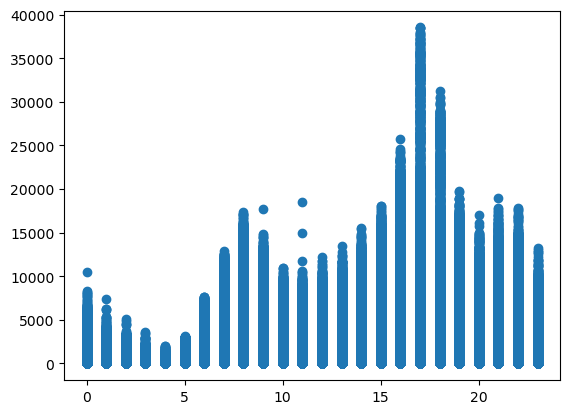

In [8]:
plt.scatter(df['hour'],df['passenger_count']);

In [35]:
# Convert categorical features into numerical using one-hot encoding
df = pd.get_dummies(df, columns=['week', 'holiday'])

In [4]:
# rolling mean and standard deviation features
df['pc_rolling_mean_3'] = df['passenger_count'].rolling(window=3).mean()
df['pc_rolling_std_3'] = df['passenger_count'].rolling(window=3).std()
df['bi_rolling_mean_3'] = df['busyness_index'].rolling(window=3).mean()
df['bi_rolling_std_3'] = df['busyness_index'].rolling(window=3).std()

In [5]:
# Create lag features for passenger count
for lag in range(1, 4):  # Example: Lag features for the past 1, 2, and 3 hours
    df[f'passenger_count_lag_{lag}'] = df.groupby('taxi_zone')['passenger_count'].shift(lag)
# Drop rows with NaN values generated by the lag
df.dropna(inplace=True)

# Create lag features for busyness index
for lag in range(1, 4):  # Example: Lag features for the past 1, 2, and 3 hours
    df[f'busyness_index_lag_{lag}'] = df.groupby('taxi_zone')['busyness_index'].shift(lag)
# Drop rows with NaN values generated by the lag
df.dropna(inplace=True)

In [6]:
df.dtypes

datetime                                                    object
taxi_zone                                                    int64
passenger_count                                            float64
temperature_2m (°C)                                        float64
rain (mm)                                                  float64
snow_depth (m)                                             float64
snowfall (cm)                                              float64
wind_speed_10m (km/h)                                      float64
day                                                          int64
hour                                                         int64
month                                                        int64
day_of_week                                                  int64
is_weekend                                                   int64
quarter                                                      int64
date                                                        ob

In [7]:
# Check and convert categorical columns (one-hot encoded)
categorical_columns = [col for col in df.columns if 'week_' in col or 'holiday_' in col]
for col in categorical_columns:
    df[col] = df[col].astype(int)

# Ensure numerical columns are of the correct type
numerical_columns = ['passenger_count', 'temperature_2m (°C)', 'rain (mm)', 'snow_depth (m)',
                     'snowfall (cm)', 'wind_speed_10m (km/h)'] + \
                    [f'passenger_count_lag_{lag}' for lag in range(1, 4)]+ \
                    [f'busyness_index_lag_{lag}' for lag in range(1, 4)]


for col in numerical_columns:
    df[col] = df[col].astype(float)
    
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])


# Display the DataFrame with the correct data types
df.dtypes

datetime                                                   datetime64[ns]
taxi_zone                                                           int64
passenger_count                                                   float64
temperature_2m (°C)                                               float64
rain (mm)                                                         float64
snow_depth (m)                                                    float64
snowfall (cm)                                                     float64
wind_speed_10m (km/h)                                             float64
day                                                                 int64
hour                                                                int64
month                                                               int64
day_of_week                                                         int64
is_weekend                                                          int64
quarter                               

In [8]:
df.isnull().sum()

datetime                                                   0
taxi_zone                                                  0
passenger_count                                            0
temperature_2m (°C)                                        0
rain (mm)                                                  0
snow_depth (m)                                             0
snowfall (cm)                                              0
wind_speed_10m (km/h)                                      0
day                                                        0
hour                                                       0
month                                                      0
day_of_week                                                0
is_weekend                                                 0
quarter                                                    0
date                                                       0
busyness_index                                             0
week_Friday             

In [9]:
df = df.drop('datetime', axis=1)
df = df.drop('date', axis=1)
df

,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,hour,month,...,pc_rolling_mean_3,pc_rolling_std_3,bi_rolling_mean_3,bi_rolling_std_3,passenger_count_lag_1,passenger_count_lag_2,passenger_count_lag_3,busyness_index_lag_1,busyness_index_lag_2,busyness_index_lag_3
6,4,471.391304,-7.4,0.0,0.64,0.21,4.4,1,6,1,...,369.282609,94.642669,4.666667,0.577350,284.500000,351.956522,523.891304,5.0,5.0,5.0
7,4,1116.391304,-6.7,0.0,0.64,0.21,4.2,1,7,1,...,624.094203,436.462389,3.666667,1.527525,471.391304,284.500000,351.956522,4.0,5.0,5.0
8,4,1985.326087,-5.8,0.0,0.64,0.07,4.1,1,8,1,...,1191.036232,759.722667,2.333333,1.527525,1116.391304,471.391304,284.500000,2.0,4.0,5.0
9,4,1410.913043,-5.0,0.0,0.64,0.00,3.8,1,9,1,...,1504.210145,441.916481,1.333333,0.577350,1985.326087,1116.391304,471.391304,1.0,2.0,4.0
10,4,1146.934783,-6.4,0.0,0.65,0.07,5.2,1,10,1,...,1514.391304,428.667479,1.000000,0.000000,1410.913043,1985.326087,1116.391304,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173171,263,1263.000000,-20.2,0.0,0.88,0.00,9.4,31,19,12,...,941.666667,288.474147,1.333333,0.577350,857.000000,705.000000,587.000000,1.0,1.0,1.0
1173172,263,1138.000000,-21.3,0.0,0.87,0.00,9.4,31,20,12,...,1086.000000,207.935086,2.000000,1.000000,1263.000000,857.000000,705.000000,2.0,1.0,1.0
1173173,263,1136.000000,-22.2,0.0,0.87,0.00,9.8,31,21,12,...,1179.000000,72.753007,2.666667,0.577350,1138.000000,1263.000000,857.000000,3.0,2.0,1.0
1173174,263,972.000000,-22.9,0.0,0.87,0.00,9.8,31,22,12,...,1082.000000,95.268043,3.000000,0.000000,1136.000000,1138.000000,1263.000000,3.0,3.0,2.0


In [10]:
for col in df.columns:
    print(col)

taxi_zone
passenger_count
temperature_2m (°C)
rain (mm)
snow_depth (m)
snowfall (cm)
wind_speed_10m (km/h)
day
hour
month
day_of_week
is_weekend
quarter
busyness_index
week_Friday
week_Monday
week_Saturday
week_Sunday
week_Thursday
week_Tuesday
week_Wednesday
holiday_Christmas Day
holiday_Christmas Day (observed)
holiday_Columbus Day
holiday_Independence Day
holiday_Juneteenth National Independence Day
holiday_Juneteenth National Independence Day (observed)
holiday_Labor Day
holiday_Martin Luther King Jr. Day
holiday_Memorial Day
holiday_New Year's Day
holiday_New Year's Day (observed)
holiday_No
holiday_Thanksgiving
holiday_Veterans Day
holiday_Veterans Day (observed)
holiday_Washington's Birthday
pc_rolling_mean_3
pc_rolling_std_3
bi_rolling_mean_3
bi_rolling_std_3
passenger_count_lag_1
passenger_count_lag_2
passenger_count_lag_3
busyness_index_lag_1
busyness_index_lag_2
busyness_index_lag_3


# Split the Data 30/70

In [11]:
# shuffle the data
df = df.sample(frac=1, random_state=987)
df.head(5)

,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,hour,month,...,pc_rolling_mean_3,pc_rolling_std_3,bi_rolling_mean_3,bi_rolling_std_3,passenger_count_lag_1,passenger_count_lag_2,passenger_count_lag_3,busyness_index_lag_1,busyness_index_lag_2,busyness_index_lag_3
114428,43,1038.000000,-23.5,0.0,1.28,0.0,6.4,23,20,1,...,1824.666667,936.793645,3.000000,0.00000,1575.000000,2861.000000,4539.000000,3.0,3.0,3.0
960111,233,2289.434783,10.1,0.0,0.00,0.0,13.8,5,7,9,...,1208.398551,988.128198,3.333333,0.57735,983.978261,351.782609,97.434783,3.0,3.0,2.0
346621,107,173.000000,13.1,0.0,0.00,0.0,6.8,24,5,8,...,123.666667,43.466462,2.333333,0.57735,107.000000,91.000000,178.000000,2.0,2.0,3.0
776106,186,4375.000000,17.5,0.0,0.00,0.0,9.1,3,10,9,...,3374.000000,1076.653612,2.333333,0.57735,3512.000000,2235.000000,1492.000000,2.0,2.0,2.0
142778,48,272.000000,1.8,0.0,0.93,0.0,3.7,20,2,4,...,539.333333,289.014417,2.000000,0.00000,500.000000,846.000000,1616.000000,2.0,2.0,3.0


In [12]:
# split data set to training data and test data
y = pd.DataFrame(df["passenger_count"])
X = df.drop(labels=["passenger_count"], axis=1)

# divide data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=93)

In [13]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,taxi_zone,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,hour,month,day_of_week,...,pc_rolling_mean_3,pc_rolling_std_3,bi_rolling_mean_3,bi_rolling_std_3,passenger_count_lag_1,passenger_count_lag_2,passenger_count_lag_3,busyness_index_lag_1,busyness_index_lag_2,busyness_index_lag_3
0,163,-2.4,0.0,0.00,0.00,8.2,5,19,10,3,...,5305.666667,1158.214286,4.000000,0.000000,5626.0,6270.0,4588.0,4.0,4.0,4.0
1,45,-1.9,0.0,0.17,0.07,4.7,13,0,5,4,...,459.666667,117.185039,3.333333,0.577350,491.0,558.0,703.0,4.0,3.0,4.0
2,261,9.3,0.0,0.59,0.00,4.6,4,6,5,2,...,478.666667,494.588044,3.333333,1.154701,332.0,74.0,37.0,4.0,2.0,2.0
3,163,4.4,0.0,0.00,0.00,5.9,28,12,8,0,...,1653.666667,38.734137,2.666667,0.577350,1678.0,1609.0,1869.0,3.0,3.0,3.0
4,41,1.8,0.0,1.31,0.14,3.2,14,5,3,0,...,213.000000,161.297861,2.666667,0.577350,146.0,96.0,137.0,3.0,2.0,3.0


In [18]:
#dictionary to store results
results = {}

# Loop over the range of max_depth values
for depth in range(6, 21, 2):
    
    # Record the start time
    start_time = time.time()
    
    # Instantiate the model with current max_depth
    xgb = XGBRegressor(n_estimators=100, max_depth=depth, learning_rate=0.1, random_state=1)
    
    # Fit the model
    xgb.fit(X_train, y_train)

    # Calculate and print the time taken
    time_taken = time.time() - start_time
    print(f"Time taken to fit the model with max_depth {depth}: {time_taken} seconds")

    # Predicted value for all examples
    xgb_predictions_train = xgb.predict(X_train).ravel()
    y_train_1d = y_train.values.ravel()

    # Calculate MAE, MSE and RMSE
    mae = metrics.mean_absolute_error(y_train_1d, xgb_predictions_train)
    mse = metrics.mean_squared_error(y_train_1d, xgb_predictions_train)
    rmse = np.sqrt(mse) # or mse**(0.5)

    print(f'For max_depth {depth}, Mean Absolute Error (MAE): {mae}')
    print(f'For max_depth {depth}, Mean Squared Error (MSE): {mse}')
    print(f'For max_depth {depth}, Root Mean Squared Error (RMSE): {rmse}')
    
    # Store the results
    results[depth] = {'Time': time_taken, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Display the results
for depth in results:
    print(f"For max_depth {depth}, Time: {results[depth]['Time']}, MAE: {results[depth]['MAE']}, MSE: {results[depth]['MSE']}, RMSE: {results[depth]['RMSE']}")

Time taken to fit the model with max_depth 6: 4.458640813827515 seconds
For max_depth 6, Mean Absolute Error (MAE): 53.0329771250716
For max_depth 6, Mean Squared Error (MSE): 14005.027704397804
For max_depth 6, Root Mean Squared Error (RMSE): 118.34283968368261
Time taken to fit the model with max_depth 8: 4.650258779525757 seconds
For max_depth 8, Mean Absolute Error (MAE): 34.38006192900332
For max_depth 8, Mean Squared Error (MSE): 6665.891622986144
For max_depth 8, Root Mean Squared Error (RMSE): 81.64491180095759
Time taken to fit the model with max_depth 10: 6.563023805618286 seconds
For max_depth 10, Mean Absolute Error (MAE): 22.036205961777906
For max_depth 10, Mean Squared Error (MSE): 2752.3258772235663
For max_depth 10, Root Mean Squared Error (RMSE): 52.46261409064141
Time taken to fit the model with max_depth 12: 12.858902931213379 seconds
For max_depth 12, Mean Absolute Error (MAE): 14.67254638400204
For max_depth 12, Mean Squared Error (MSE): 1074.1867968053393
For max

In [20]:
# Define a dictionary to store results
results = {}

# Define range of hyperparameters
depth_range = [10,12, 14]
learning_rate_range = [0.1, 0.2]
n_estimators_range = [100, 200]

# Loop over the range of max_depth values, learning_rate, and n_estimators
for depth in depth_range:
    for learning_rate in learning_rate_range:
        for n_estimators in n_estimators_range:
            print("depth", depth, "learning_rate", learning_rate, "n_estimators_range", n_estimators)
    
            # Record the start time
            start_time = time.time()
            
            # Instantiate the model with current max_depth, learning_rate, and n_estimators
            xgb = XGBRegressor(n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate, random_state=1)

            # Fit the model
            xgb.fit(X_train, y_train)

            # Calculate and print the time taken
            time_taken = time.time() - start_time
            print(f"Time taken to fit the model with max_depth {depth}, learning_rate {learning_rate}, and n_estimators {n_estimators}: {time_taken} seconds")

            # Predicted value for all examples
            xgb_predictions_train = xgb.predict(X_train).ravel()
            y_train_1d = y_train.values.ravel()
            xgb_predictions_test = xgb.predict(X_test).ravel()
            y_test_1d = y_test.values.ravel()

            # Calculate MAE, MSE and RMSE for train data
            train_mae = metrics.mean_absolute_error(y_train_1d, xgb_predictions_train)
            train_mse = metrics.mean_squared_error(y_train_1d, xgb_predictions_train)
            train_rmse = np.sqrt(train_mse) 

            # Calculate MAE, MSE and RMSE for test data
            test_mae = metrics.mean_absolute_error(y_test_1d, xgb_predictions_test)
            test_mse = metrics.mean_squared_error(y_test_1d, xgb_predictions_test)
            test_rmse = np.sqrt(test_mse)
            
            
            print("==================== Test Data =======================")
            print('Mean Absolute Error (MAE):', test_mae)
            print('Mean Squared Error (MSE):', test_mse)
            print('Root Mean Squared Error (RMSE):', test_rmse)

            print("==================== Train Data =======================")
            print('Mean Absolute Error (MAE):', mae)
            print('Mean Squared Error (MSE):', mse)
            print('Root Mean Squared Error (RMSE):', rmse)

            # Store the results
            results[(depth, learning_rate, n_estimators)] = {'Train Time': time_taken, 'Train MAE': train_mae, 'Train MSE': train_mse, 'Train RMSE': train_rmse,
                                                             'Test MAE': test_mae, 'Test MSE': test_mse, 'Test RMSE': test_rmse}

# Display the results
for key in results:
    print(f"For max_depth {key[0]}, learning_rate {key[1]}, and n_estimators {key[2]}, Train Time: {results[key]['Train Time']}, Train MAE: {results[key]['Train MAE']}, Train MSE: {results[key]['Train MSE']}, Train RMSE: {results[key]['Train RMSE']}, Test MAE: {results[key]['Test MAE']}, Test MSE: {results[key]['Test MSE']}, Test RMSE: {results[key]['Test RMSE']}")

depth 10 learning_rate 0.1 n_estimators_range 100
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 100: 6.563259601593018 seconds
==================== Test Data =======================
Mean Absolute Error (MAE): 26.196960679862997
Mean Squared Error (MSE): 6763.2845628579325
Root Mean Squared Error (RMSE): 82.23919116125798
==================== Train Data =======================
Mean Absolute Error (MAE): 2.393807024266876
Mean Squared Error (MSE): 21.47062317946194
Root Mean Squared Error (RMSE): 4.633640380895127
depth 10 learning_rate 0.1 n_estimators_range 200
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 200: 9.747366189956665 seconds
==================== Test Data =======================
Mean Absolute Error (MAE): 24.900326278615157
Mean Squared Error (MSE): 6282.980356251057
Root Mean Squared Error (RMSE): 79.26525314569466
==================== Train Data =======================
Mean Absolute Error (MAE): 2.3

In [21]:
import pickle

# Define a dictionary to store results
results = {}

# Define range of hyperparameters
depth_range = [10,12, 14]
learning_rate_range = [0.1, 0.2]
n_estimators_range = [100, 200]

# Loop over the range of max_depth values, learning_rate, and n_estimators
for depth in depth_range:
    for learning_rate in learning_rate_range:
        for n_estimators in n_estimators_range:
            print("depth", depth, "learning_rate", learning_rate, "n_estimators_range", n_estimators)
    
            # Record the start time
            start_time = time.time()
            
            # Instantiate the model with current max_depth, learning_rate, and n_estimators
            xgb = XGBRegressor(n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate, random_state=1)

            # Fit the model
            xgb.fit(X_train, y_train)

            # Calculate and print the time taken
            time_taken = time.time() - start_time
            print(f"Time taken to fit the model with max_depth {depth}, learning_rate {learning_rate}, and n_estimators {n_estimators}: {time_taken} seconds")

depth 10 learning_rate 0.1 n_estimators_range 100
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 100: 7.127389192581177 seconds
depth 10 learning_rate 0.1 n_estimators_range 200
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 200: 10.049479961395264 seconds
depth 10 learning_rate 0.2 n_estimators_range 100
Time taken to fit the model with max_depth 10, learning_rate 0.2, and n_estimators 100: 6.579283237457275 seconds
depth 10 learning_rate 0.2 n_estimators_range 200
Time taken to fit the model with max_depth 10, learning_rate 0.2, and n_estimators 200: 11.382790088653564 seconds
depth 12 learning_rate 0.1 n_estimators_range 100
Time taken to fit the model with max_depth 12, learning_rate 0.1, and n_estimators 100: 12.813250064849854 seconds
depth 12 learning_rate 0.1 n_estimators_range 200
Time taken to fit the model with max_depth 12, learning_rate 0.1, and n_estimators 200: 18.62291669845581 seconds
depth 12 lear

In [22]:
# instantiate the model
xgb = XGBRegressor(n_estimators=200, max_depth=12, learning_rate=0.1, random_state=1)

# record the start time
start_time = time.time()

# fit the model
xgb.fit(X_train, y_train)

# calculate and print the time taken
time_taken = time.time() - start_time
print(f"Time taken to fit the model: {time_taken} seconds")

import pickle

# Save the model to disk
filename = 'XGboost_model_depth_12_lr_0.1_estimators_200.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgb, file)

print(f"Model saved as {filename}")

Time taken to fit the model: 15.409680366516113 seconds
Model saved as XGboost_model_depth_12_lr_0.1_estimators_200.pkl


In [23]:
# Predicted value for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
xgb_predictions_train = xgb.predict(X_train).ravel()
y_train_1d = y_train.values.ravel()

df_true_vs_xgb_predicted = pd.DataFrame({'Actual': y_train_1d, 'Predicted': xgb_predictions_train})
df_true_vs_xgb_predicted.head(20)

,Actual,Predicted
0,4021.0,3970.685059
1,330.0,322.757294
2,1030.0,1031.341431
3,1674.0,1686.173706
4,397.0,395.163055
5,130.0,132.297913
6,3032.0,3034.603760
7,3801.0,3827.730469
8,392.0,377.202209
9,191.0,198.599915


In [24]:
# Calculate MAE, MSE and RMSE
mae = metrics.mean_absolute_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
mse = metrics.mean_squared_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
rmse = np.sqrt(mse) # or mse**(0.5)  

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 12.203300567225995
Mean Squared Error (MSE): 520.2300029524163
Root Mean Squared Error (RMSE): 22.808551092790097


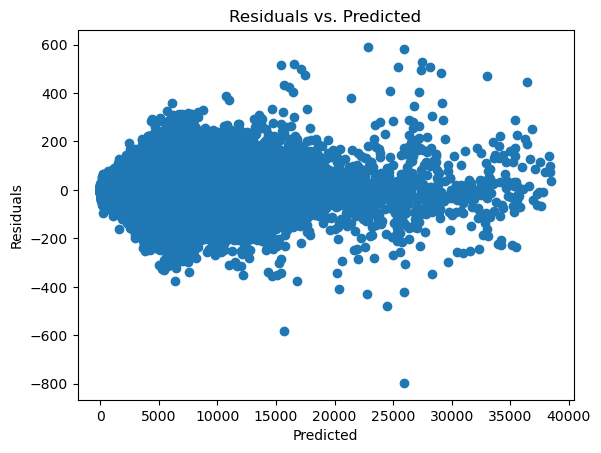

In [25]:
# Convert to DataFrame
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
xgb_predictions_train_df = pd.DataFrame(xgb_predictions_train, columns=['Predicted']).reset_index(drop=True)

# Calculate residuals
residuals = y_train_df['passenger_count'] - xgb_predictions_train_df['Predicted']

# Plot residuals
plt.scatter(xgb_predictions_train_df, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

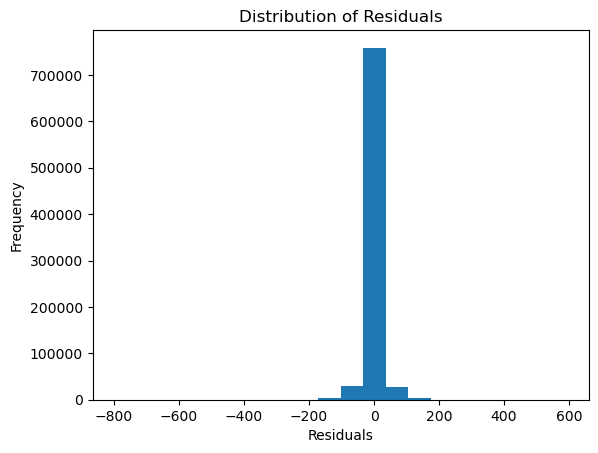

In [28]:
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [29]:
print(len(y_train))
print(len(xgb_predictions_train))

820937
820937


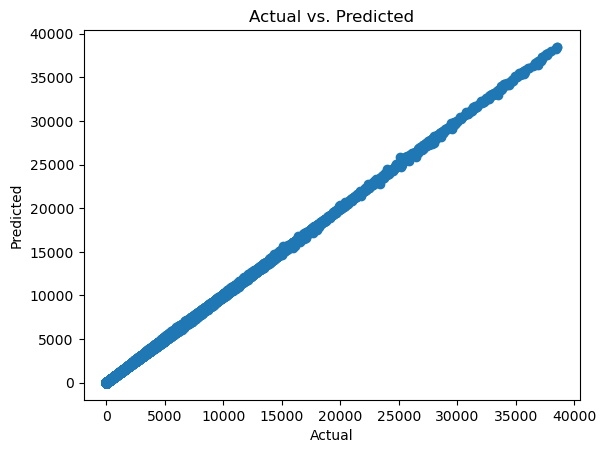

In [30]:
plt.scatter(y_train, xgb_predictions_train)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [31]:
# Predicted value for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
xgb_predictions_test = xgb.predict(X_test).ravel()
y_test_1d = y_test.values.ravel()

df_true_vs_xgb_predicted = pd.DataFrame({'Actual': y_test_1d, 'Predicted': xgb_predictions_test})
df_true_vs_xgb_predicted.head(20)

,Actual,Predicted
0,2632.000000,2624.639160
1,239.000000,236.684128
2,203.000000,198.010269
3,2270.000000,2271.086914
4,3462.000000,3534.637451
5,334.000000,317.596802
6,1969.000000,1975.953247
7,4629.000000,4715.828125
8,184.000000,193.979614
9,4484.000000,4492.176758


# Feature Importance

It seems the model really relies on passenger_count_mean_3. This could be a problem as not really sure this can fit into our model predictions. Will need reviewed

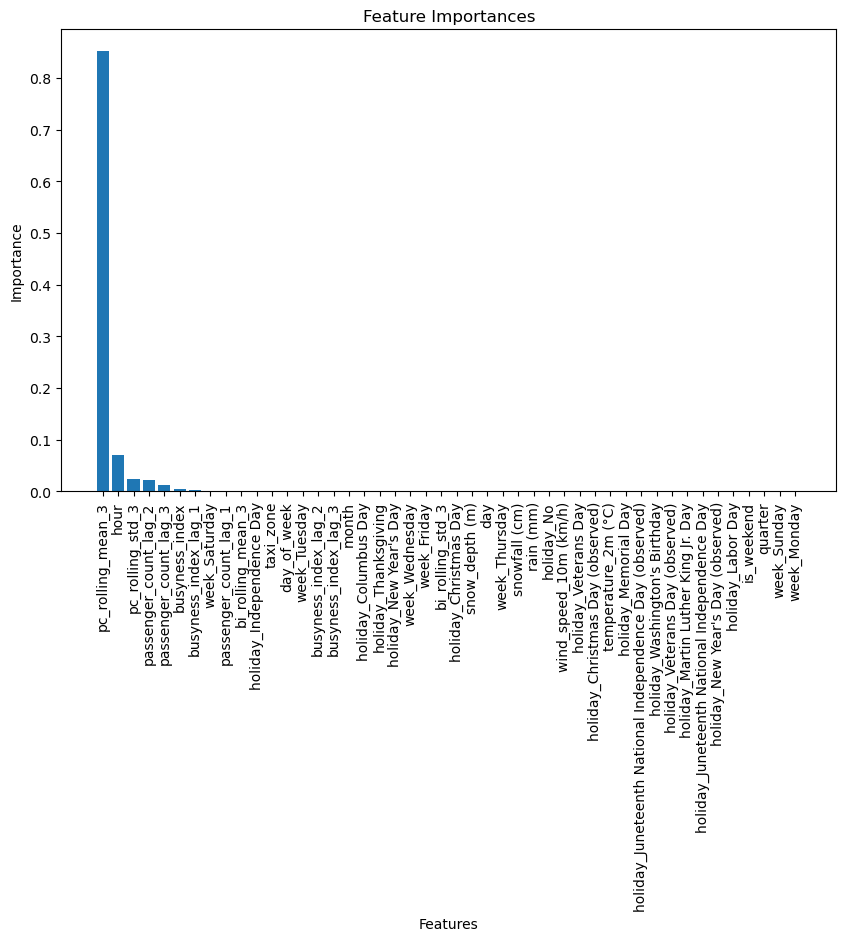

In [33]:
# Extract feature importances
feature_importances = xgb.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [32]:
# Calculate MAE, MSE and RMSE
test_mae = metrics.mean_absolute_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
test_mse = metrics.mean_squared_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
test_rmse = np.sqrt(mse) # or mse**(0.5) 
print("==================== Test Data =======================")
print('Mean Absolute Error (MAE):', test_mae)
print('Mean Squared Error (MSE):', test_mse)
print('Root Mean Squared Error (RMSE):', test_rmse)

print("==================== Train Data =======================")
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

==================== Test Data =======================
Mean Absolute Error (MAE): 21.47174781529233
Mean Squared Error (MSE): 6029.475010897042
Root Mean Squared Error (RMSE): 22.808551092790097
==================== Train Data =======================
Mean Absolute Error (MAE): 12.203300567225995
Mean Squared Error (MSE): 520.2300029524163
Root Mean Squared Error (RMSE): 22.808551092790097


# Try Model Again and remove all features that involve passenger count and busyness index

In [25]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz
import time
from xgboost import XGBRegressor

In [17]:
df = pd.read_csv('basic_prepared_data_2.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df.head()

,datetime,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,week,hour,month,holiday,day_of_week,is_weekend,quarter,date,busyness_index
0,2022-01-01 00:00:00,4,890.500000,-17.0,0.0,0.64,0.00,8.3,1,Saturday,0,1,New Year's Day,5,1,1,2022-01-01,3
1,2022-01-01 01:00:00,4,793.239130,-15.6,0.0,0.64,0.07,8.0,1,Saturday,1,1,New Year's Day,5,1,1,2022-01-01,4
2,2022-01-01 02:00:00,4,686.500000,-14.7,0.0,0.64,0.07,7.6,1,Saturday,2,1,New Year's Day,5,1,1,2022-01-01,4
3,2022-01-01 03:00:00,4,523.891304,-14.2,0.0,0.64,0.07,7.0,1,Saturday,3,1,New Year's Day,5,1,1,2022-01-01,5
4,2022-01-01 04:00:00,4,351.956522,-12.6,0.0,0.64,0.14,7.0,1,Saturday,4,1,New Year's Day,5,1,1,2022-01-01,5


In [18]:
# Convert categorical features into numerical using one-hot encoding
df = pd.get_dummies(df, columns=['week', 'holiday','month','hour'])

In [19]:
df.dtypes

datetime                object
taxi_zone                int64
passenger_count        float64
temperature_2m (°C)    float64
rain (mm)              float64
                        ...   
hour_19                   bool
hour_20                   bool
hour_21                   bool
hour_22                   bool
hour_23                   bool
Length: 73, dtype: object

In [20]:
# Check and convert categorical columns (one-hot encoded)
categorical_columns = [col for col in df.columns if 'week_' in col or 'holiday_' in col]
for col in categorical_columns:
    df[col] = df[col].astype(int)

# Ensure numerical columns are of the correct type
numerical_columns = ['passenger_count', 'temperature_2m (°C)', 'rain (mm)', 'snow_depth (m)',
                     'snowfall (cm)', 'wind_speed_10m (km/h)']

for col in numerical_columns:
    df[col] = df[col].astype(float)
    
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])


# Display the DataFrame with the correct data types
df.dtypes

datetime               datetime64[ns]
taxi_zone                       int64
passenger_count               float64
temperature_2m (°C)           float64
rain (mm)                     float64
                            ...      
hour_19                          bool
hour_20                          bool
hour_21                          bool
hour_22                          bool
hour_23                          bool
Length: 73, dtype: object

In [21]:
df = df.drop('datetime', axis=1)
df = df.drop('date', axis=1)
df

,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,day_of_week,is_weekend,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,4,890.500000,-17.0,0.0,0.64,0.00,8.3,1,5,1,...,False,False,False,False,False,False,False,False,False,False
1,4,793.239130,-15.6,0.0,0.64,0.07,8.0,1,5,1,...,False,False,False,False,False,False,False,False,False,False
2,4,686.500000,-14.7,0.0,0.64,0.07,7.6,1,5,1,...,False,False,False,False,False,False,False,False,False,False
3,4,523.891304,-14.2,0.0,0.64,0.07,7.0,1,5,1,...,False,False,False,False,False,False,False,False,False,False
4,4,351.956522,-12.6,0.0,0.64,0.14,7.0,1,5,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173171,263,1263.000000,-20.2,0.0,0.88,0.00,9.4,31,6,1,...,False,False,False,False,False,True,False,False,False,False
1173172,263,1138.000000,-21.3,0.0,0.87,0.00,9.4,31,6,1,...,False,False,False,False,False,False,True,False,False,False
1173173,263,1136.000000,-22.2,0.0,0.87,0.00,9.8,31,6,1,...,False,False,False,False,False,False,False,True,False,False
1173174,263,972.000000,-22.9,0.0,0.87,0.00,9.8,31,6,1,...,False,False,False,False,False,False,False,False,True,False


In [22]:
for col in df.columns:
    print(col)

taxi_zone
passenger_count
temperature_2m (°C)
rain (mm)
snow_depth (m)
snowfall (cm)
wind_speed_10m (km/h)
day
day_of_week
is_weekend
quarter
busyness_index
week_Friday
week_Monday
week_Saturday
week_Sunday
week_Thursday
week_Tuesday
week_Wednesday
holiday_Christmas Day
holiday_Christmas Day (observed)
holiday_Columbus Day
holiday_Independence Day
holiday_Juneteenth National Independence Day
holiday_Juneteenth National Independence Day (observed)
holiday_Labor Day
holiday_Martin Luther King Jr. Day
holiday_Memorial Day
holiday_New Year's Day
holiday_New Year's Day (observed)
holiday_No
holiday_Thanksgiving
holiday_Veterans Day
holiday_Veterans Day (observed)
holiday_Washington's Birthday
month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
hour_0
hour_1
hour_2
hour_3
hour_4
hour_5
hour_6
hour_7
hour_8
hour_9
hour_10
hour_11
hour_12
hour_13
hour_14
hour_15
hour_16
hour_17
hour_18
hour_19
hour_20
hour_21
hour_22
hour_23


In [23]:
# shuffle the data
df = df.sample(frac=1, random_state=987)
df.head(5)

,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,day_of_week,is_weekend,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
374724,114,66.0,-5.0,0.0,0.64,0.21,3.4,8,1,0,...,False,False,False,False,False,False,False,False,False,False
149289,48,1014.0,-16.0,0.0,1.35,0.00,8.7,16,0,0,...,False,False,False,False,False,False,False,False,False,False
366221,113,2626.0,-7.9,0.0,0.07,0.00,3.8,18,5,1,...,False,False,False,False,False,False,False,True,False,False
271198,88,412.0,-17.0,0.0,1.13,0.00,6.5,16,4,0,...,False,False,False,False,False,False,False,False,True,False
988321,236,1627.0,-8.1,0.0,0.93,0.00,5.6,24,3,0,...,False,False,False,True,False,False,False,False,False,False


In [24]:
# split data set to training data and test data
y = pd.DataFrame(df["passenger_count"])
X = df.drop(labels=["passenger_count","busyness_index"], axis=1)

# divide data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=93)

In [25]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,taxi_zone,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,day_of_week,is_weekend,quarter,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,209,7.3,0.0,0.01,0.00,6.1,20,4,0,4,...,False,False,False,False,False,False,False,False,False,False
1,12,3.4,0.0,1.30,0.00,5.4,27,0,0,1,...,False,False,False,False,False,False,False,False,False,False
2,229,-12.7,0.0,1.16,0.07,0.8,5,0,0,4,...,False,False,False,False,False,False,False,False,False,False
3,162,-7.6,0.0,1.08,0.00,5.1,19,5,1,1,...,True,False,False,False,False,False,False,False,False,False
4,127,-9.8,0.0,0.73,0.07,3.6,2,2,0,1,...,False,False,False,False,False,False,False,False,False,False


In [35]:
#dictionary to store results
results = {}

# Loop over the range of max_depth values
for depth in range(6, 21, 2):
    
    # Record the start time
    start_time = time.time()
    
    # Instantiate the model with current max_depth
    xgb = XGBRegressor(n_estimators=100, max_depth=depth, learning_rate=0.1, random_state=1)
    
    # Fit the model
    xgb.fit(X_train, y_train)

    # Calculate and print the time taken
    time_taken = time.time() - start_time
    print(f"Time taken to fit the model with max_depth {depth}: {time_taken} seconds")

    # Predicted value for all examples
    xgb_predictions_train = xgb.predict(X_train).ravel()
    y_train_1d = y_train.values.ravel()

    # Calculate MAE, MSE and RMSE
    mae = metrics.mean_absolute_error(y_train_1d, xgb_predictions_train)
    mse = metrics.mean_squared_error(y_train_1d, xgb_predictions_train)
    rmse = np.sqrt(mse) # or mse**(0.5)

    print(f'For max_depth {depth}, Mean Absolute Error (MAE): {mae}')
    print(f'For max_depth {depth}, Mean Squared Error (MSE): {mse}')
    print(f'For max_depth {depth}, Root Mean Squared Error (RMSE): {rmse}')
    
    # Store the results
    results[depth] = {'Time': time_taken, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Display the results
for depth in results:
    print(f"For max_depth {depth}, Time: {results[depth]['Time']}, MAE: {results[depth]['MAE']}, MSE: {results[depth]['MSE']}, RMSE: {results[depth]['RMSE']}")

Time taken to fit the model with max_depth 6: 6.974214315414429 seconds
For max_depth 6, Mean Absolute Error (MAE): 529.4264376154388
For max_depth 6, Mean Squared Error (MSE): 747365.917928573
For max_depth 6, Root Mean Squared Error (RMSE): 864.5032781479622
Time taken to fit the model with max_depth 8: 7.242172718048096 seconds
For max_depth 8, Mean Absolute Error (MAE): 382.3898649581854
For max_depth 8, Mean Squared Error (MSE): 367875.3579314452
For max_depth 8, Root Mean Squared Error (RMSE): 606.5272936409747
Time taken to fit the model with max_depth 10: 8.535935640335083 seconds
For max_depth 10, Mean Absolute Error (MAE): 271.2059418343553
For max_depth 10, Mean Squared Error (MSE): 192481.1964265597
For max_depth 10, Root Mean Squared Error (RMSE): 438.72679018560024
Time taken to fit the model with max_depth 12: 12.431595087051392 seconds
For max_depth 12, Mean Absolute Error (MAE): 192.42742639375285
For max_depth 12, Mean Squared Error (MSE): 96149.72527689785
For max_de

In [36]:
# Define a dictionary to store results
results = {}

# Define range of hyperparameters
depth_range = [10, 12, 14]
learning_rate_range = [0.1, 0.2]
n_estimators_range = [100, 200]

# Loop over the range of max_depth values, learning_rate, and n_estimators
for depth in depth_range:
    for learning_rate in learning_rate_range:
        for n_estimators in n_estimators_range:
            print("depth", depth, "learning_rate", learning_rate, "n_estimators_range", n_estimators)
    
            # Record the start time
            start_time = time.time()
            
            # Instantiate the model with current max_depth, learning_rate, and n_estimators
            xgb = XGBRegressor(n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate, random_state=1)

            # Fit the model
            xgb.fit(X_train, y_train)

            # Calculate and print the time taken
            time_taken = time.time() - start_time
            print(f"Time taken to fit the model with max_depth {depth}, learning_rate {learning_rate}, and n_estimators {n_estimators}: {time_taken} seconds")

            # Predicted value for all examples
            xgb_predictions_train = xgb.predict(X_train).ravel()
            y_train_1d = y_train.values.ravel()
            xgb_predictions_test = xgb.predict(X_test).ravel()
            y_test_1d = y_test.values.ravel()

            # Calculate MAE, MSE and RMSE for train data
            train_mae = metrics.mean_absolute_error(y_train_1d, xgb_predictions_train)
            train_mse = metrics.mean_squared_error(y_train_1d, xgb_predictions_train)
            train_rmse = np.sqrt(train_mse) 

            # Calculate MAE, MSE and RMSE for test data
            test_mae = metrics.mean_absolute_error(y_test_1d, xgb_predictions_test)
            test_mse = metrics.mean_squared_error(y_test_1d, xgb_predictions_test)
            test_rmse = np.sqrt(test_mse)
            
            
            print("==================== Test Data =======================")
            print('Mean Absolute Error (MAE):', test_mae)
            print('Mean Squared Error (MSE):', test_mse)
            print('Root Mean Squared Error (RMSE):', test_rmse)

            print("==================== Train Data =======================")
            print('Mean Absolute Error (MAE):', mae)
            print('Mean Squared Error (MSE):', mse)
            print('Root Mean Squared Error (RMSE):', rmse)

            # Store the results
            results[(depth, learning_rate, n_estimators)] = {'Train Time': time_taken, 'Train MAE': train_mae, 'Train MSE': train_mse, 'Train RMSE': train_rmse,
                                                             'Test MAE': test_mae, 'Test MSE': test_mse, 'Test RMSE': test_rmse}

# Display the results
for key in results:
    print(f"For max_depth {key[0]}, learning_rate {key[1]}, and n_estimators {key[2]}, Train Time: {results[key]['Train Time']}, Train MAE: {results[key]['Train MAE']}, Train MSE: {results[key]['Train MSE']}, Train RMSE: {results[key]['Train RMSE']}, Test MAE: {results[key]['Test MAE']}, Test MSE: {results[key]['Test MSE']}, Test RMSE: {results[key]['Test RMSE']}")

depth 10 learning_rate 0.1 n_estimators_range 100
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 100: 10.505275011062622 seconds
==================== Test Data =======================
Mean Absolute Error (MAE): 277.3744221083658
Mean Squared Error (MSE): 208709.58526320462
Root Mean Squared Error (RMSE): 456.8474420013804
==================== Train Data =======================
Mean Absolute Error (MAE): 43.947140392305734
Mean Squared Error (MSE): 6137.873636139652
Root Mean Squared Error (RMSE): 78.3445826853373
depth 10 learning_rate 0.1 n_estimators_range 200
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 200: 16.713998794555664 seconds
==================== Test Data =======================
Mean Absolute Error (MAE): 212.8236027714779
Mean Squared Error (MSE): 129024.19268682243
Root Mean Squared Error (RMSE): 359.1993773474871
==================== Train Data =======================
Mean Absolute Error (MAE): 43

In [37]:
import pickle

# Define a dictionary to store results
results = {}

# Define range of hyperparameters
depth_range = [10, 12, 14]
learning_rate_range = [0.1, 0.2]
n_estimators_range = [100, 200]

# Loop over the range of max_depth values, learning_rate, and n_estimators
for depth in depth_range:
    for learning_rate in learning_rate_range:
        for n_estimators in n_estimators_range:
            print("depth", depth, "learning_rate", learning_rate, "n_estimators_range", n_estimators)
    
            # Record the start time
            start_time = time.time()
            
            # Instantiate the model with current max_depth, learning_rate, and n_estimators
            xgb = XGBRegressor(n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate, random_state=1)

            # Fit the model
            xgb.fit(X_train, y_train)

            # Calculate and print the time taken
            time_taken = time.time() - start_time
            print(f"Time taken to fit the model with max_depth {depth}, learning_rate {learning_rate}, and n_estimators {n_estimators}: {time_taken} seconds")

depth 10 learning_rate 0.1 n_estimators_range 100
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 100: 11.550822019577026 seconds
depth 10 learning_rate 0.1 n_estimators_range 200
Time taken to fit the model with max_depth 10, learning_rate 0.1, and n_estimators 200: 17.87998056411743 seconds
depth 10 learning_rate 0.2 n_estimators_range 100
Time taken to fit the model with max_depth 10, learning_rate 0.2, and n_estimators 100: 11.047851800918579 seconds
depth 10 learning_rate 0.2 n_estimators_range 200
Time taken to fit the model with max_depth 10, learning_rate 0.2, and n_estimators 200: 18.16011881828308 seconds
depth 12 learning_rate 0.1 n_estimators_range 100
Time taken to fit the model with max_depth 12, learning_rate 0.1, and n_estimators 100: 17.073691844940186 seconds
depth 12 learning_rate 0.1 n_estimators_range 200
Time taken to fit the model with max_depth 12, learning_rate 0.1, and n_estimators 200: 24.30006456375122 seconds
depth 12 lear

In [38]:
# instantiate the model
xgb = XGBRegressor(n_estimators=200, max_depth=12, learning_rate=0.1, random_state=1)

# record the start time
start_time = time.time()

# fit the model
xgb.fit(X_train, y_train)

# calculate and print the time taken
time_taken = time.time() - start_time
print(f"Time taken to fit the model: {time_taken} seconds")

import pickle

#save the model to disk
filename = 'XGboost_model_depth_12_lr_0.1_estimators_200_2.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgb, file)

print(f"Model saved as {filename}")

Time taken to fit the model: 23.39981436729431 seconds
Model saved as XGboost_model_depth_12_lr_0.1_estimators_200_2.pkl


In [26]:
#load the model
filename = 'XGboost_model_depth_12_lr_0.1_estimators_200_2.pkl'
with open(filename, 'rb') as file:
    xgb = pickle.load(file)

print("Model loaded successfully")

Model loaded successfully


In [27]:
# Predicted value for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
xgb_predictions_train = xgb.predict(X_train).ravel()
y_train_1d = y_train.values.ravel()

df_true_vs_xgb_predicted = pd.DataFrame({'Actual': y_train_1d, 'Predicted': xgb_predictions_train})
df_true_vs_xgb_predicted.head(20)

,Actual,Predicted
0,2684.000000,2351.423584
1,1332.152174,1281.494873
2,129.000000,168.111603
3,3281.000000,3257.321777
4,503.000000,372.928192
5,1102.000000,1046.539795
6,102.000000,87.996872
7,409.000000,463.579437
8,388.000000,595.380981
9,34.000000,66.539383


In [40]:
# Calculate MAE, MSE and RMSE
mae = metrics.mean_absolute_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
mse = metrics.mean_squared_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
rmse = np.sqrt(mse) # or mse**(0.5)  

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 142.03643418410468
Mean Squared Error (MSE): 53581.851326285774
Root Mean Squared Error (RMSE): 231.47753957195454


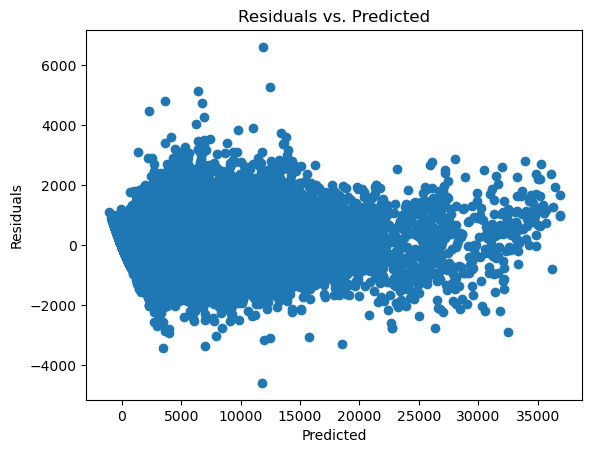

In [41]:
# Convert to DataFrame
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
xgb_predictions_train_df = pd.DataFrame(xgb_predictions_train, columns=['Predicted']).reset_index(drop=True)

# Calculate residuals
residuals = y_train_df['passenger_count'] - xgb_predictions_train_df['Predicted']

# Plot residuals
plt.scatter(xgb_predictions_train_df, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

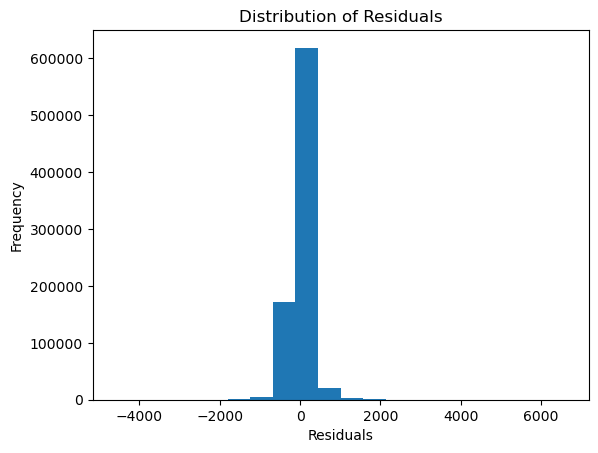

In [42]:
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

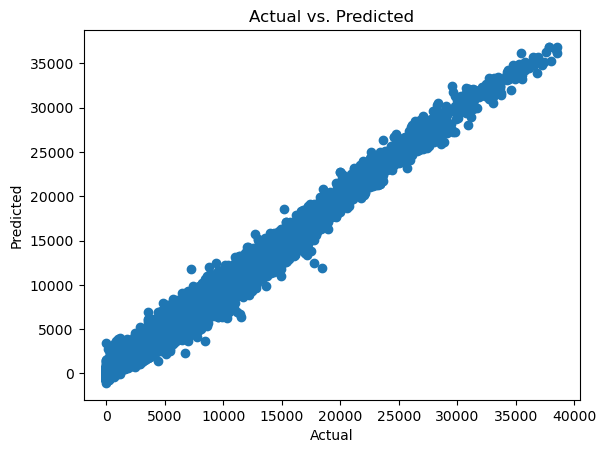

In [43]:
plt.scatter(y_train, xgb_predictions_train)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [44]:
# Predicted value for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
xgb_predictions_test = xgb.predict(X_test).ravel()
y_test_1d = y_test.values.ravel()

df_true_vs_xgb_predicted = pd.DataFrame({'Actual': y_test_1d, 'Predicted': xgb_predictions_test})
df_true_vs_xgb_predicted.head(20)

,Actual,Predicted
0,3159.000000,3092.941895
1,3052.000000,3182.394043
2,768.000000,906.961121
3,1700.000000,1588.010132
4,74.000000,122.790207
5,453.000000,400.967987
6,1863.000000,1874.485596
7,1169.000000,1175.224731
8,705.000000,891.457886
9,188.000000,268.486633


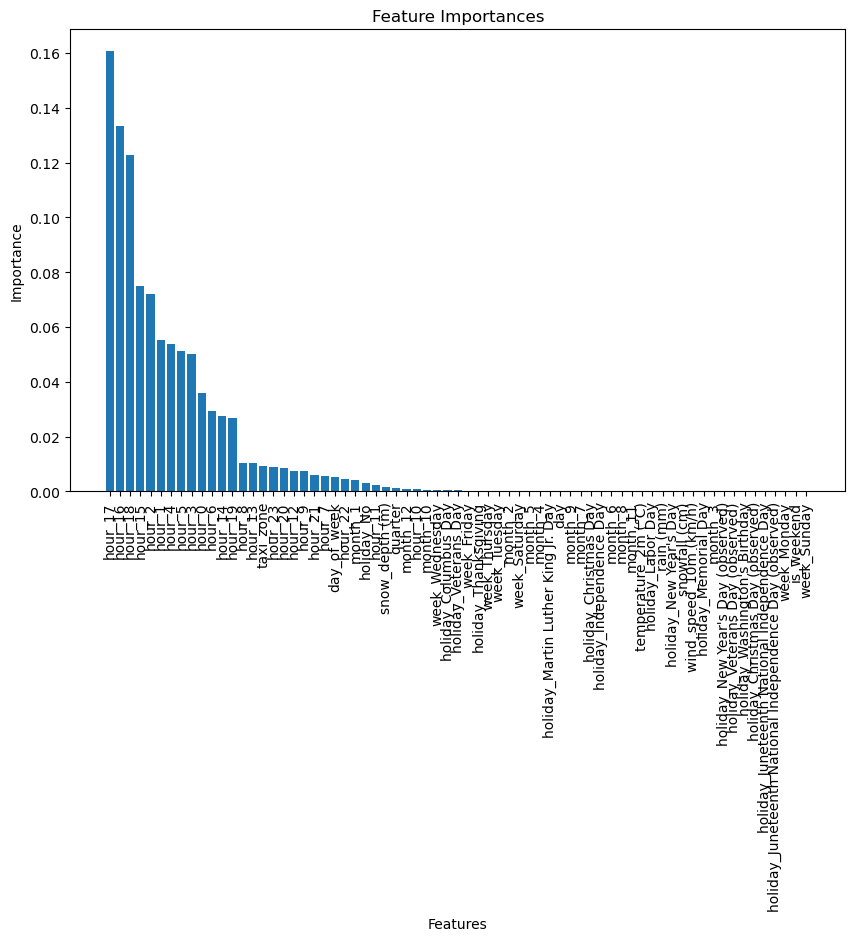

In [45]:
# Extract feature importances
feature_importances = xgb.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [46]:
# Calculate MAE, MSE and RMSE
test_mae = metrics.mean_absolute_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
test_mse = metrics.mean_squared_error(df_true_vs_xgb_predicted['Actual'], df_true_vs_xgb_predicted['Predicted'])
test_rmse = np.sqrt(mse) # or mse**(0.5) 
print("==================== Test Data =======================")
print('Mean Absolute Error (MAE):', test_mae)
print('Mean Squared Error (MSE):', test_mse)
print('Root Mean Squared Error (RMSE):', test_rmse)

print("==================== Train Data =======================")
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

==================== Test Data =======================
Mean Absolute Error (MAE): 165.51149818634974
Mean Squared Error (MSE): 88150.7310989915
Root Mean Squared Error (RMSE): 231.47753957195454
==================== Train Data =======================
Mean Absolute Error (MAE): 142.03643418410468
Mean Squared Error (MSE): 53581.851326285774
Root Mean Squared Error (RMSE): 231.47753957195454


# Sample Input Row

In [38]:
#sample input row
sample_input_row = {
    'datetime': '2023-06-01 12:00:00',
    'taxi_zone': 263,
    'temperature_2m (°C)': 25.0,
    'rain (mm)': 0.0,
    'snow_depth (m)': 0.0,
    'snowfall (cm)': 0.0,
    'wind_speed_10m (km/h)': 10.0,
    'day': 1,
    'hour': 12,
    'holiday': 'No',
    'week': 'Thursday'
}

sample_input_df = pd.DataFrame([sample_input_row])

#match training data
sample_input_df['day_of_week'] = pd.to_datetime(sample_input_df['datetime']).dt.dayofweek
sample_input_df['is_weekend'] = sample_input_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
sample_input_df['quarter'] = pd.to_datetime(sample_input_df['datetime']).dt.quarter
sample_input_df['month'] = pd.to_datetime(sample_input_df['datetime']).dt.month

#dummy encoding for categorical variables
sample_input_df = pd.get_dummies(sample_input_df, columns=['week', 'holiday', 'hour', 'month'], drop_first=True)

#align columns with training data
expected_features = [
    'taxi_zone', 'temperature_2m (°C)', 'rain (mm)', 'snow_depth (m)', 'snowfall (cm)', 'wind_speed_10m (km/h)', 
    'day', 'day_of_week', 'is_weekend', 'quarter', 
    'week_Friday', 'week_Monday', 'week_Saturday', 'week_Sunday', 'week_Thursday', 'week_Tuesday', 'week_Wednesday', 
    'holiday_Christmas Day', 'holiday_Christmas Day (observed)', 'holiday_Columbus Day', 'holiday_Independence Day', 
    'holiday_Juneteenth National Independence Day', 'holiday_Juneteenth National Independence Day (observed)', 
    'holiday_Labor Day', 'holiday_Martin Luther King Jr. Day', 'holiday_Memorial Day', "holiday_New Year's Day", 
    "holiday_New Year's Day (observed)", 'holiday_No', 'holiday_Thanksgiving', 'holiday_Veterans Day', 
    'holiday_Veterans Day (observed)', "holiday_Washington's Birthday", 
    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 
    'month_11', 'month_12', 
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 
    'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 
    'hour_21', 'hour_22', 'hour_23'
]

#reindex the df to have all the expected features
sample_input_df = sample_input_df.reindex(columns=expected_features, fill_value=0)

#load the model
sample_prediction = xgb.predict(sample_input_df)

print("Prediction:", sample_prediction[0])

Prediction: 1011.9672


In [42]:
sample_input_df

,taxi_zone,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,day_of_week,is_weekend,quarter,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,263,25.0,0.0,0.0,0.0,10.0,1,3,0,2,...,0,0,0,0,0,0,0,0,0,0


In [43]:
sample_input_df.to_csv("sample_input_row.csv", index=False)